In [2]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re #importo 
from datetime import date #importo

from collections import Counter
from collections import defaultdict

In [3]:
class_name = 'Occupancy'
df = pd.read_csv('datatestcopy2(2)copy.csv', skipinitialspace=True, na_values='?', keep_default_na=True, parse_dates=True)
# aggiungiamo dopo la key: index_col='date', parse_dates=True

columns2remove = ['number'] #eliminiamo perchè non ci servono
df.drop(columns2remove, inplace=True, axis=1)
df.head()

,date,Temperature,Humidity,light,CO2,HumidityRatio,Occupancy
0,2/2/15 14:19,23.7000,26.272,585.200000,749.200000,0.004764,1
1,2/2/15 14:19,23.7180,26.290,578.400000,760.400000,0.004773,1
2,2/2/15 14:21,23.7300,26.230,572.666667,769.666667,0.004765,1
3,2/2/15 14:22,23.7225,26.125,493.750000,774.750000,0.004744,1
4,2/2/15 14:23,23.7540,26.200,488.600000,779.000000,0.004767,1


In [4]:
def prepare_dataset(df, class_name):
    df = remove_missing_values(df)
    
    
    numeric_columns = get_numeric_columns(df)
    rdf = df.copy(deep=True)
    df, feature_names, class_values = one_hot_encoding(df, class_name)
    real_feature_names = get_real_feature_names(rdf, numeric_columns, class_name)
    rdf = rdf[real_feature_names + (class_values if isinstance(class_name, list) else [class_name])]
    features_map = get_features_map(feature_names, real_feature_names)

    return df, feature_names, class_values, numeric_columns, rdf, real_feature_names, features_map

def remove_missing_values(df):
    for column_name, nbr_missing in df.isna().sum().to_dict().items():
        if nbr_missing > 0:
            if column_name in df._get_numeric_data().columns:
                mean = df[column_name].mean()
                df[column_name].fillna(mean, inplace=True)
            else:
                mode = df[column_name].mode().values[0]
                df[column_name].fillna(mode, inplace=True)
    return df

def get_numeric_columns(df):
    numeric_columns = list(df._get_numeric_data().columns)
    return numeric_columns

def get_real_feature_names(rdf, numeric_columns, class_name):
    real_feature_names = [c for c in rdf.columns if c in numeric_columns and c != class_name]
    real_feature_names += [c for c in rdf.columns if c not in numeric_columns and c != class_name]
    return real_feature_names

def one_hot_encoding(df, class_name):
    dfX = pd.get_dummies(df[[c for c in df.columns if c != class_name]], prefix_sep='=')
    class_name_map = {v: k for k, v in enumerate(sorted(df[class_name].unique()))}
    dfY = df[class_name].map(class_name_map)
    df = pd.concat([dfX, dfY], axis=1, join_axes=[dfX.index])
    feature_names = list(dfX.columns)
    class_values = sorted(class_name_map)
    return df, feature_names, class_values

def get_features_map(feature_names, real_feature_names):
    features_map = defaultdict(dict)
    i = 0
    j = 0

    while i < len(feature_names) and j < len(real_feature_names):
        if feature_names[i] == real_feature_names[j]:
            features_map[j][feature_names[i]] = j
            i += 1
            j += 1
        elif feature_names[i].startswith(real_feature_names[j]):
            features_map[j][feature_names[i]] = j
            i += 1
        else:
            j += 1
    return features_map

#----------------------------------------------------------------------
#creiamo una nuova variabile che assegna valore 1 ai giorni da Lun a Ven
#0 per Sab e Dom

def convert_date(date_in_str):
    
    date_list = re.findall(r"\w+", date_in_str)
    month = date_list[0]
    dat = date_list[1]
    year = '20' + date_list[2]
    num_day = date(int(year),int(month),int(dat)).weekday()    


    # 0 è lunedi', 2 è mercoledi 
    #dobbiamo convertire 5 e 6 in 0 per definirle come weekend days (sabato e domenica )

    if num_day >= 5:
        return 0 
    else:
        return 1

In [5]:
df['Week_day'] = df.date.apply(convert_date)

In [6]:
df.head()

,date,Temperature,Humidity,light,CO2,HumidityRatio,Occupancy,Week_day
0,2/2/15 14:19,23.7000,26.272,585.200000,749.200000,0.004764,1,1
1,2/2/15 14:19,23.7180,26.290,578.400000,760.400000,0.004773,1,1
2,2/2/15 14:21,23.7300,26.230,572.666667,769.666667,0.004765,1,1
3,2/2/15 14:22,23.7225,26.125,493.750000,774.750000,0.004744,1,1
4,2/2/15 14:23,23.7540,26.200,488.600000,779.000000,0.004767,1,1


In [7]:
columns2remove = ['date'] #eliminiamo perchè non ci servono
df.drop(columns2remove, inplace=True, axis=1)


In [8]:
df.head() #abbiamo eliminato la data

,Temperature,Humidity,light,CO2,HumidityRatio,Occupancy,Week_day
0,23.7000,26.272,585.200000,749.200000,0.004764,1,1
1,23.7180,26.290,578.400000,760.400000,0.004773,1,1
2,23.7300,26.230,572.666667,769.666667,0.004765,1,1
3,23.7225,26.125,493.750000,774.750000,0.004744,1,1
4,23.7540,26.200,488.600000,779.000000,0.004767,1,1


In [9]:
res = prepare_dataset(df, class_name)
df, feature_names, class_values, numeric_columns, rdf, real_feature_names, features_map = res
df.head()

,Temperature,Humidity,light,CO2,HumidityRatio,Week_day,Occupancy
0,23.7000,26.272,585.200000,749.200000,0.004764,1,1
1,23.7180,26.290,578.400000,760.400000,0.004773,1,1
2,23.7300,26.230,572.666667,769.666667,0.004765,1,1
3,23.7225,26.125,493.750000,774.750000,0.004744,1,1
4,23.7540,26.200,488.600000,779.000000,0.004767,1,1


In [13]:
attributes = [col for col in df.columns if col != class_name]
X = df[attributes].values
y = df[class_name]

In [17]:
X.shape

(2665, 6)

In [18]:
from sklearn.tree import DecisionTreeClassifier

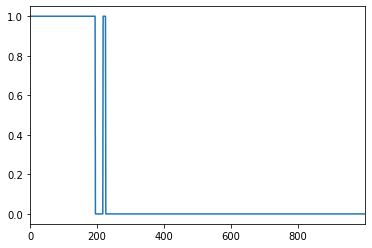

In [21]:

from matplotlib import pyplot
df.Occupancy[0:1000].plot()

pyplot.show()

In [26]:
print(min(df["Temperature"]))
print(max(df["Temperature"]))

20.2
24.40833333


In [30]:

def molt(a,b):
    i=a
    c=0
    while i>0:
        c+=b
        i-=1
    return c
print(molt(23,56))
23*56
%timeit molt(23,56)

1288
2.87 µs ± 131 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)
